<h1 style="text-align: center; font-size: 36px; color: #3498db; font-weight: bold;">Prosody Tools</h1>

## <h2 style="text-align: center; font-size: 28px; color: #2ecc71; font-weight: bold;">Prosody API Tool</h2>
### <h3 style="text-align: center; font-size: 24px; color: #e74c3c; font-family: 'Arial', sans-serif; font-weight: bold;">Server</h3>


### Receive the voice, Send back the prediction

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from emotion2vecplus import Emotion2Vec
import numpy as np

emotion2vec = Emotion2Vec()

class EmotionPlotter:
    def __init__(self):
        self.class_names = ["Noise", "angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
        self.prediction_history = []

        # histogram figure
        self.fig_histogram, self.ax_histogram = plt.subplots(figsize=(12, 8))
        self.ax_histogram.set_title('Prosody Prediction Histogram')
        self.ax_histogram.set_xlabel('Emotion')
        self.ax_histogram.set_ylabel('Probability (%)')
        self.ax_histogram.set_ylim(0, 100)
        self.ax_histogram.set_xticks(np.arange(len(self.class_names)))
        self.ax_histogram.set_xticklabels(self.class_names, rotation=0)

        # Russell Map figure
        self.fig_russell, self.ax_russell = plt.subplots(figsize=(12, 8))
        self.ax_russell.set_title('Prosody Russell Map')
        self.ax_russell.set_xlim(-1, 1)
        self.ax_russell.set_ylim(-1, 1)
        self.ax_russell.set_xlabel('Valence')
        self.ax_russell.set_ylabel('Arousal')
        self.ax_russell.axhline(0, color='gray', lw=1)
        self.ax_russell.axvline(0, color='gray', lw=1)

        # Emotion coordinates
        self.emotion_coordinates = {
            "angry": (-0.40, 0.79),
            "disgust": (-0.68, -0.37),
            "fear": (-0.12, 0.79),
            "happy": (0.89, 0.17),
            "neutral": (0.00, 0.00),
            "sad": (-0.81, -0.40),
            "surprise": (0.70, 0.71)
        }

    def update_plot(self, predicted_probs):
        # Validate probabilities
        if not any(predicted_probs[1:]):  # Ensure at least one non-zero probability
            raise ValueError("Predicted probabilities contain all zeros or invalid values.")
        
        # Plot the histogram
        self.ax_histogram.clear()
        self.ax_histogram.bar(self.class_names, predicted_probs * 100, color='skyblue')


        # Save the histogram
        histogram_path = './Images/prosody_histogram.png'
        self.fig_histogram.savefig(histogram_path)
        print(f"Histogram saved at {histogram_path}")
        plt.close(self.fig_histogram) 
        
        # Exclude 'Noise'
        total_percentage = sum(predicted_probs[1:])
        if total_percentage <= 0:
            raise ValueError("Invalid total_percentage; check predicted_probs values.")


        # weighted valence and arousal
        weighted_valence = 0
        weighted_arousal = 0
        for i, emotion in enumerate(self.class_names[1:]):  # Skip 'Noise'
            valence, arousal = self.emotion_coordinates.get(emotion, (0, 0))
            weighted_valence += valence * predicted_probs[i + 1]
            weighted_arousal += arousal * predicted_probs[i + 1]

        weighted_valence /= total_percentage
        weighted_arousal /= total_percentage



        # Mood data 
        data = {
            "mood": [
                "sleepy & tired", ".", "afraid", "angry", "calm", "relaxed", "content",
                "depressed", "discontent", "determined", "happy", "anxious", "good",
                "pensive", "impressed", "frustrated", "disappointed", "bored", "annoyed",
                "enraged", "excited", "melancholy", "satisfied", "distressed",
                "uncomfortable", "worried", "amused", "apathetic", "peaceful",
                "contemplative", "embarrassed", "sad", "hopeful", "pleased", "None"
            ],
            "valence": [
                0.01, -0.01, -0.12, -0.40, 0.78, 0.71, 0.81, -0.81, -0.68, 0.73, 0.89, -0.72, 0.90,
                0.09, 0.39, -0.60, -0.80, -0.35, -0.44, -0.18, 0.70, -0.05, 0.77, -0.71,
                -0.68, -0.07, 0.55, -0.20, 0.55, 0.58, -0.31, -0.81, 0.61, 0.89, 0.00
            ],
            "arousal": [
                -1.00, -1.00, 0.79, 0.79, -0.68, -0.65, -0.55, -0.48, -0.32, 0.26, 0.17, -0.80, -0.08,
                -0.60, -0.06, 0.40, -0.03, -0.78, 0.76, 0.83, 0.71, -0.65, -0.63, 0.55,
                -0.37, -0.32, 0.19, -0.12, -0.80, -0.60, -0.60, -0.40, -0.30, -0.10, 0.00
            ],
            "#posts": [
                11549, 20308, 20, 3152, 10040, 3545, 11177, 6383, 2490, 3360, 16518, 7039, 5062,
                2322, 1610, 4356, 3328, 12784, 8247, 1016, 11074, 2274, 2629, 2233,
                1763, 3252, 24231, 2732, 2513, 10718, 1092, 6119, 5312, 3517, 3000
            ]
        }

        df = pd.DataFrame(data)
        
        self.ax_russell.clear()
        # historical points 
        for valence, arousal in self.prediction_history:
            self.ax_russell.scatter(valence, arousal, color='orange', s=300, alpha=0.5, label="History")

        # add new point to history
        self.prediction_history.append((weighted_valence, weighted_arousal))

        # current valence-arousal point
        self.ax_russell.scatter(weighted_valence, weighted_arousal, color= ('red', 0.6), s=2000, label='Predicted Emotion')

        # Plot mood points
        self.ax_russell.scatter(df['valence'], df['arousal'], s=df['#posts'], alpha=0.5, label='Moods')

        # Annotate moods
        for i, row in df.iterrows():
            self.ax_russell.text(row['valence'], row['arousal'], row['mood'], fontsize=9, ha='right')

        #self.ax_russell.legend(loc='upper right')


        os.makedirs('./Images', exist_ok=True)

        # Save Russell Map plot
        russell_path = './Images/prosody_map.png'
        self.fig_russell.savefig(russell_path)
        print(f"Russell Map saved at {russell_path}")

        # (non-blocking for debugging)
        plt.show(self.fig_russell, block=False)
        plt.close(self.fig_russell)



def process_wav_file(wav_file_path):
    try:
        emotion, probabilities = emotion2vec.predict(wav_file_path)
        return emotion, probabilities
    except Exception as e:
        print(f"Error processing file: {e}")
        return None, [0] * 8  # Return zeros on failure for debugging


2025-01-09 19:51:17,662 - modelscope - WARNING - Using branch: master as version is unstable, use with caution


Detect model requirements, begin to install it: C:\Users\Alkostantini-GIGA\.cache\modelscope\hub\iic\emotion2vec_plus_large\requirements.txt
install model requirements successfully
ckpt: C:\Users\Alkostantini-GIGA\.cache\modelscope\hub\iic\emotion2vec_plus_large\model.pt
init param, map: modality_encoders.AUDIO.extra_tokens from d2v_model.modality_encoders.AUDIO.extra_tokens in ckpt
init param, map: modality_encoders.AUDIO.alibi_scale from d2v_model.modality_encoders.AUDIO.alibi_scale in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.0.weight from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.0.weight in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.weight from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.weight in ckpt
init param, map: modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.bias from d2v_model.modality_encoders.AUDIO.local_encoder.conv_layers.0.2.1.bias in ckpt
init param, 

Connected to broker at tekolabserv.reutlingen-university.de:18883
Server is running and waiting for voice files...
Waiting for the voice...
Voice file received.
Voice file saved to received_voice.wav


rtf_avg: 0.531: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]                                                                                      


生气/angry
rec_result: {'key': 'received_voice', 'labels': ['生气/angry', '厌恶/disgusted', '恐惧/fearful', '开心/happy', '中立/neutral', '其他/other', '难过/sad', '吃惊/surprised', '<unk>'], 'scores': [0.5510683655738831, 0.2996538579463959, 0.08006870746612549, 0.010259336791932583, 0.00024609305546619, 0.0008793537854216993, 0.0026862728409469128, 0.05496981367468834, 0.00016808485088404268]}
Histogram saved at ./Images/prosody_histogram.png
Russell Map saved at ./Images/prosody_map.png


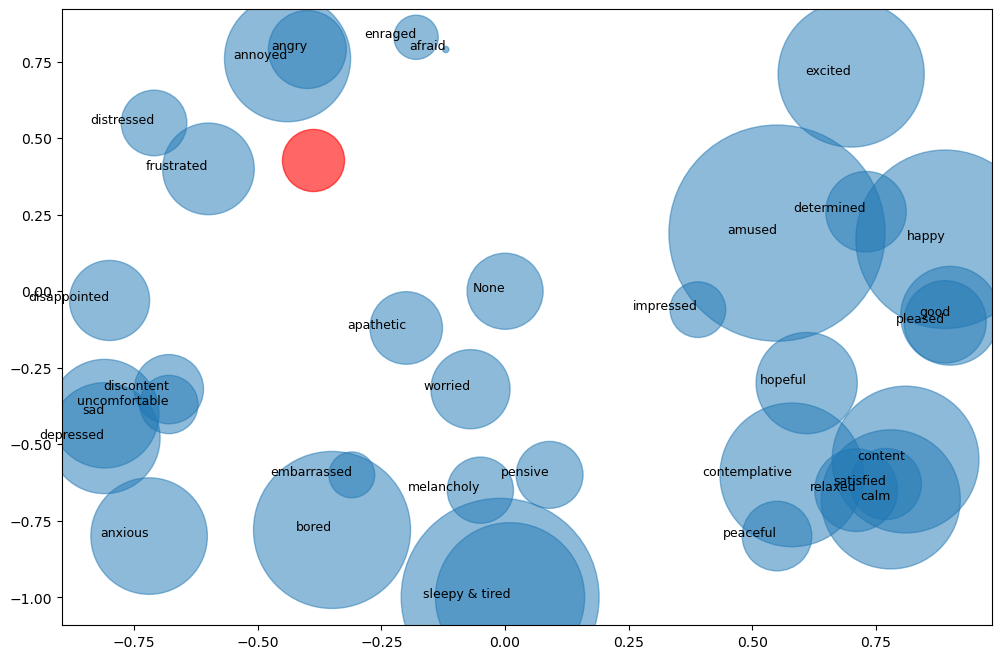

Sent histogram back.
Sent prosody map back.
Sent string response.
Waiting for the voice...
Voice file received.
Voice file saved to received_voice.wav


rtf_avg: 0.603: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]                                                                                      


生气/angry
rec_result: {'key': 'received_voice', 'labels': ['生气/angry', '厌恶/disgusted', '恐惧/fearful', '开心/happy', '中立/neutral', '其他/other', '难过/sad', '吃惊/surprised', '<unk>'], 'scores': [0.5510683655738831, 0.2996538579463959, 0.08006870746612549, 0.010259336791932583, 0.00024609305546619, 0.0008793537854216993, 0.0026862728409469128, 0.05496981367468834, 0.00016808485088404268]}
Histogram saved at ./Images/prosody_histogram.png
Russell Map saved at ./Images/prosody_map.png


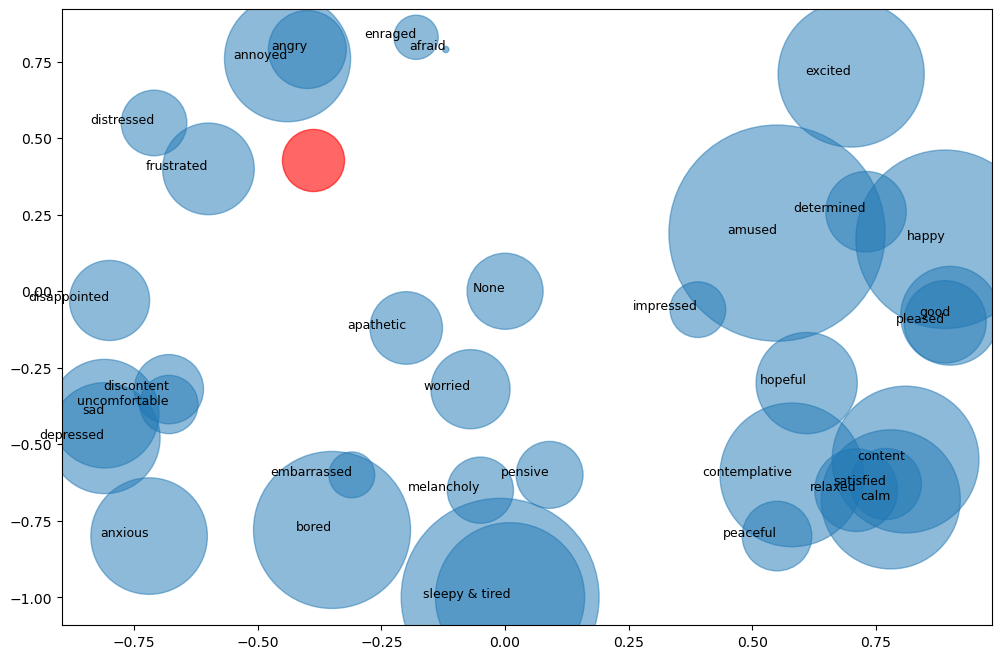

Sent histogram back.
Sent prosody map back.
Sent string response.


In [ ]:
from paho.mqtt import client as mqtt_client
import os
import time

# Server configuration
BROKER_ADDRESS = "tekolabserv.reutlingen-university.de"
broker_port = 18883
username = "hsrt"
password = "M0squitt0HSRTPassw0rt!"

VOICE_TOPIC = "pros/voice/send"
IMAGE1_TOPIC = "pros/image/receive1"
IMAGE2_TOPIC = "pros/image/receive2"
STRING_TOPIC = "pros/string/receive"
client_id = "server"

os.makedirs("./Images", exist_ok=True)

# Callback 
def on_message(client, userdata, message):
    print("Waiting for the voice...")

    if message.topic == VOICE_TOPIC:
        print("Voice file received.")
        voice_file_path = "received_voice.wav"
        
        try:
            # Save the voice
            with open(voice_file_path, "wb") as f:
                f.write(message.payload)
            print(f"Voice file saved to {voice_file_path}")
        except Exception as e:
            print(f"Failed to save voice file: {e}")
            return

        try:
            # Process the voice
            plotter = EmotionPlotter()
            prediction, probabilities = process_wav_file(voice_file_path)
            plotter.update_plot(probabilities)

            # Publish histogram
            with open(r"./Images/prosody_histogram.png", "rb") as img1:
                client.publish(IMAGE1_TOPIC, img1.read(), qos=1, retain=True)
                print("Sent histogram back.")

            # Publish prosody map
            with open(r"./Images/prosody_map.png", "rb") as img2:
                client.publish(IMAGE2_TOPIC, img2.read(), qos=1, retain=True)
                print("Sent prosody map back.")

            # Publish response string
            response_string = f"{probabilities}"
            client.publish(STRING_TOPIC, response_string, qos=1, retain=True)
            print("Sent string response.")
        except Exception as e:
            print(f"Error during processing or publishing: {e}")

# client
client = mqtt_client.Client(mqtt_client.CallbackAPIVersion.VERSION2, client_id)
client.username_pw_set(username, password)
client.on_message = on_message

try:
    # Connect to broker
    client.connect(BROKER_ADDRESS, broker_port)
    print(f"Connected to broker at {BROKER_ADDRESS}:{broker_port}")
except Exception as e:
    print(f"Failed to connect to broker: {e}")
    exit(1)

# Subscribe to the voice topic
client.subscribe(VOICE_TOPIC)

print("Server is running and waiting for voice files...")
client.loop_forever()
